### Student Name: EPHANTUS WANDUA.  
 - PROJECT TITLE : SPAM VS HAM  
 - COURSE CODE : ECE 590   
 - COURSE TITLE : NEURAL NETWORK  

### Loading the required libraries

In [1]:

from pathlib import Path
import pandas as pd
import os, json, time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, classification_report,confusion_matrix, ConfusionMatrixDisplay


In [2]:
%cd

C:\Users\ephan


In [3]:
csv_path = Path(r"spam.csv")

In [4]:
df = pd.read_csv(csv_path, encoding ='latin-1')

### Coercing into a standard schema

In [5]:
if {"v1","v2"}.issubset(df.columns):
    df = df.rename(columns={"v1":"label", "v2":"text"})
df = df[["label","text"]].dropna()
df["y"] = (df["label"].str.lower().eq("spam")).astype(int)

print(df.shape, df["y"].mean())  # rows, spam rate
df.head()

(5572, 3) 0.13406317300789664


,label,text,y
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Spliting `Training` `Validation` amd `Test` data.

In [6]:
train_df, test_df = train_test_split(df[["text","y"]],
                                     test_size=0.20, random_state=42,
                                     stratify=df["y"])
train_df, val_df  = train_test_split(train_df,
                                     test_size=0.20, random_state=42,
                                     stratify=train_df["y"])

vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
Xtr = vec.fit_transform(train_df.text)
Xva = vec.transform(val_df.text)
Xte = vec.transform(test_df.text)

ytr, yva, yte = train_df.y.values, val_df.y.values, test_df.y.values
Xtr.shape, Xva.shape, Xte.shape

((3565, 9638), (892, 9638), (1115, 9638))

### Training a compact Keras MLP with early stopping
> For reproducability, i am going to set seet at the conventionall 42

In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
tf.random.set_seed(42); np.random.seed(42)
def _to_dense(X):
    return X.toarray().astype("float32") if hasattr(X, "toarray") else X.astype("float32")

ART = Path("artifacts"); ART.mkdir(exist_ok=True)
TIMESTAMP = time.strftime("%Y-%m-%d_%H-%M-%S")

### Threshold tuning on validation

In [9]:
Xtr_d = Xtr.toarray().astype("float32")
Xva_d = Xva.toarray().astype("float32")
Xte_d = Xte.toarray().astype("float32")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(Xtr_d.shape[1],)),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="roc_auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    Xtr_d, ytr,
    validation_data=(Xva_d, yva),
    epochs=50, batch_size=64, callbacks=[es], verbose=0
)

print("Best val AUC:", max(history.history["val_roc_auc"]))


Best val AUC: 0.9885038733482361


### I will continue by turning the threshold decision on the validation set for F1 and then evaluate on the held-out test set.

In [10]:
pva = model.predict(Xva_d, verbose=0).ravel()
grid = np.linspace(0.1, 0.9, 33)
f1s = [f1_score(yva, (pva >= t).astype(int)) for t in grid]
best_t = grid[np.argmax([f1_score(yva, (pva>=t).astype(int)) for t in grid])]

pte = model.predict(Xte_d, verbose=0).ravel()
yhat = (pte >= best_t).astype(int)
cm = confusion_matrix(yte, yhat)

test_f1  = f1_score(yte, yhat)
test_roc = roc_auc_score(yte, pte)
test_pr  = average_precision_score(yte, pte)
rep_txt = classification_report(yte, yhat, target_names=["ham","spam"], digits=3)

print("Chosen threshold:", round(float(best_t), 3))
print(f"Best val F1: {max(f1s):.4f}")
print("F1:", round(f1_score(yte, yhat), 4))
print("ROC-AUC:", round(roc_auc_score(yte, pte), 4))
print("PR-AUC:", round(average_precision_score(yte, pte), 4))
print("\nReport:\n", classification_report(yte, yhat, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(yte, yhat))

Chosen threshold: 0.75
Best val F1: 0.9437
F1: 0.9371
ROC-AUC: 0.9863
PR-AUC: 0.9678

Report:
               precision    recall  f1-score   support

           0      0.985     0.997     0.991       966
           1      0.978     0.899     0.937       149

    accuracy                          0.984      1115
   macro avg      0.981     0.948     0.964      1115
weighted avg      0.984     0.984     0.984      1115


Confusion matrix:
 [[963   3]
 [ 15 134]]


### I will save the artifacts

In [11]:
from joblib import dump

model_path = ART / "keras_nlp_spam.keras"            
vec_path   = ART / "tfidf_vectorizer.joblib"
metrics_js = ART / "metrics.json"
report_txt = ART / "classification_report.txt"
preds_csv  = ART / "test_predictions.csv"

### Saving model in native format

In [12]:
model.save(model_path)
dump(vec, vec_path)

with open(report_txt, "w", encoding="utf-8") as f:
    f.write(rep_txt)

metrics = {
    "timestamp": TIMESTAMP,
    "threshold": best_t,
    "test": {"f1": float(test_f1), "roc_auc": float(test_roc), "pr_auc": float(test_pr)}
}
with open(metrics_js, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

### i will save email per test probabilities

In [13]:
pd.DataFrame({
    "proba_spam": pte,
    "pred_label": yhat,
    "true_label": yte
}).to_csv(preds_csv, index=False)

print("Saved:")
print(" ", model_path)
print(" ", vec_path)
print(" ", metrics_js)
print(" ", report_txt)
print(" ", preds_csv)

Saved:
  artifacts\keras_nlp_spam.keras
  artifacts\tfidf_vectorizer.joblib
  artifacts\metrics.json
  artifacts\classification_report.txt
  artifacts\test_predictions.csv


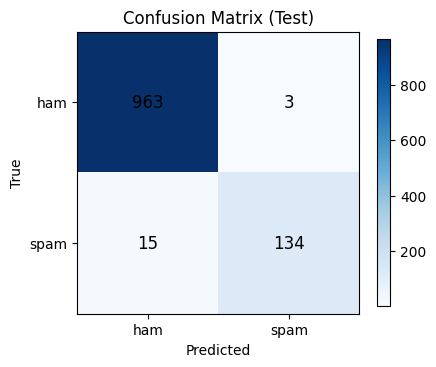

Saved: artifacts\confusion_matrix.png


In [14]:
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(cm, cmap="Blues")
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f"{val}", va="center", ha="center", fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["ham","spam"]); ax.set_yticklabels(["ham","spam"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Test)")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
cm_png = ART / "confusion_matrix.png"
plt.savefig(cm_png, dpi=150)
plt.show()

print(f"Saved: {cm_png}")

In [15]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=200, n_jobs=None)
logit.fit(Xtr, ytr)

pte_lr = logit.predict_proba(Xte)[:,1]
yhat_lr = (pte_lr >= 0.5).astype(int)

print("LogReg  ROC-AUC:", round(roc_auc_score(yte, pte_lr), 4))
print("LogReg  F1:", round(f1_score(yte, yhat_lr), 4))


LogReg  ROC-AUC: 0.9887
LogReg  F1: 0.8626


### Quick demo predicting a raw SMS/email string

In [16]:
def predict_sms(text: str, threshold: float = None):
    t = best_t if threshold is None else float(threshold)
    X = vec.transform([text])
    p = float(model.predict(_to_dense(X), verbose=0).ravel()[0])
    return {"proba_spam": round(p, 4), "label": "spam" if p >= t else "ham", "threshold": t}

print(predict_sms("WINNER! Claim your free cruise now. Reply STOP to unsubscribe."))
print(predict_sms("Hi, are we still on for the 3pm meeting?"))

{'proba_spam': 0.9599, 'label': 'spam', 'threshold': np.float64(0.75)}
{'proba_spam': 0.0019, 'label': 'ham', 'threshold': np.float64(0.75)}


In [17]:
test_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts!!! Text WIN to 87121",
    "Hey, can we move the meeting to 3pm?"
]
Xnew = vec.transform(test_messages).toarray().astype("float32")
pnew = model.predict(Xnew, verbose=0).ravel()
preds = (pnew >= best_t).astype(int)
for m, p, yb in zip(test_messages, pnew, preds):
    print(f"[{yb} | prob={p:.3f}] {m[:80]}...")


[1 | prob=0.933] Free entry in 2 a wkly comp to win FA Cup final tkts!!! Text WIN to 87121...
[0 | prob=0.004] Hey, can we move the meeting to 3pm?...


### Creating zip artifacts and the notebook for upload

In [18]:
import zipfile
Z = zipfile.ZipFile(f"Ephantus_Project_submission_{TIMESTAMP}.zip", "w", zipfile.ZIP_DEFLATED)
for p in ["artifacts", "Spam vs Ham project.ipynb"]:
    if Path(p).is_dir():
        for q in Path(p).rglob("*"):
            Z.write(q, Path("bundle")/q)
    elif Path(p).is_file():
        Z.write(p, Path("bundle")/Path(p).name)
Z.close()
print("Created:", Z.filename)


Created: Ephantus_Project_submission_2025-12-10_08-01-37.zip
